In [1]:
import numpy as np
import tensorflow as tf
import retro
from skimage import transform 
from skimage.color import rgb2gray
import matplotlib.pyplot as plt 
from collections import deque
import random 
import warnings 
warnings.filterwarnings('ignore')
import keras

Using TensorFlow backend.


In [2]:
!nvidia-smi

Mon Jan  6 20:51:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
| 27%   33C    P8    10W / 250W |    275MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9535642682542113430
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13915401992804756720
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16024946115325929669
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10701609370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 371990741308517688
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
### create environment
env=retro.make('SpaceInvaders-Atari2600')

In [5]:
print('Observation space :', env.observation_space)
print('Action Space :',env.action_space)

Observation space : Box(210, 160, 3)
Action Space : MultiBinary(8)


In [6]:
possible_actions =np.array(np.identity(env.action_space.n,dtype=int).tolist())
possible_actions 

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]])

In [7]:
from IPython import display
def show_state(env,r=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s |reward:%d Step: %d" % (info,r,step))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
display.clear_output(wait=True)

In [9]:
[env.get_action_meaning(act) for act in possible_actions]

[['BUTTON'], [], [], [], ['UP'], ['DOWN'], ['LEFT'], ['RIGHT']]

In [10]:
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

In [11]:
env.action_space.sample()

array([1, 1, 0, 0, 1, 0, 1, 0], dtype=int8)

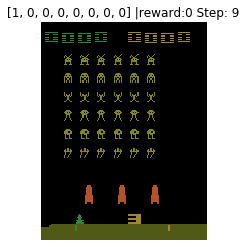

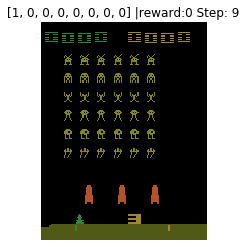

In [12]:
env.reset()
#shoot
# for action in possible_actions[-1] :

#action=[shot, 0, 0, 0, 0, 0, left, right]

action=[0, 0, 0, 0, 0, 0, 1, 0]
#action=env.action_space.sample()
tr=0
for i in range(10):
    if i%1==0 :
        action=[1, 0, 0, 0, 0, 0, 0, 0]
        print(action)
    else :
        action=[0, 0, 0, 0, 0, 0, 1, 0]
    _,r,_,_=env.step(action)
    _,r,_,_=env.step(action)
    tr+=r
    show_state(env,tr,i,str(action))
    #print(r,action)
    
    

In [13]:
#### preprocessing the image :
"""
    preprocess_frame:
    Take a frame.
    Grayscale it
    Resize it.
        __________________
        |                 |
        |                 |
        |                 |
        |                 |
        |_________________|
        
        to
        _____________
        |            |
        |            |
        |            |
        |____________|
    Normalize it.
    
    return preprocessed_frame
    
    """
def preprocess_frame(frame):
    #grascale 
    gray=rgb2gray(frame)
    #crop screen below player and on sides 
    #[up:down,left:right]
    cropped_frame=gray[8:-12,4:-12]
    #Normalise Pixel values
    normalised_frame=cropped_frame/225.0
    #Resize
    preprocessed_frame=transform.resize(normalised_frame,[110,84])
    return(preprocessed_frame)

In [14]:
%matplotlib inline

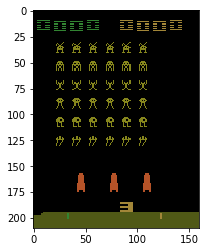

In [15]:
fr_sample=env.reset()
gray=rgb2gray(fr_sample)
plt.imshow(fr_sample,cmap='gray')

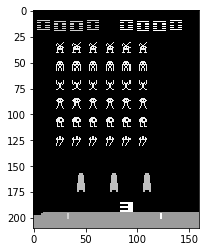

In [16]:
plt.imshow(gray,cmap='gray')

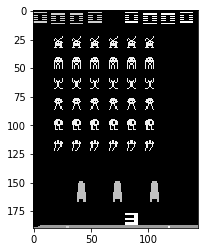

In [17]:
cropped_frame=gray[8:-12,4:-12]
plt.imshow(cropped_frame,cmap='gray')

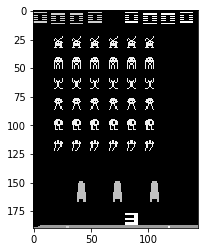

In [18]:
normalised_frame=cropped_frame/225.0
plt.imshow(normalised_frame,cmap='gray')

In [19]:
normalised_frame.shape

(190, 144)

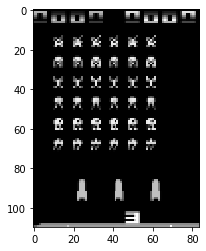

In [20]:
preprocessed_frame=transform.resize(normalised_frame,[110,84])
plt.imshow(preprocessed_frame,cmap='gray')

In [21]:
### hyper parameters 
state_size =[110,84,4]
action_size=env.action_space.n

#training 
total_episodes=100
max_steps =50000
batch_size=64
learning_rate= 0.01

#Exploration parameter
explore_start=1
explore_stop=0.01
decay_rate=0.00001

#Qlearning parameter 
gamma=0.9

#Memory 
pretrain_length=batch_size
memory_size=65000


stack_size=4

#mode
training = True
episode_render=False


# FIXED Q TARGETS HYPERPARAMETERS 
max_tau = 10000 #Tau is the C step where we update our target network


In [22]:
### stack multiple frame to create a sequence. usign deque fifo
stacked_frames =deque([np.zeros((110,84),dtype=np.int) for i in range(stack_size) ],maxlen=stack_size)
stacked_frames

deque([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]])])

In [23]:
def prep_stack_frames(stacked_frames,state,is_new_episode):
    frame=preprocess_frame(state)
    if is_new_episode :
        stacked_frames =deque([np.zeros((110,84),dtype=np.int) for i in range(stack_size) ],maxlen=stack_size)
        #new episode we put first frame in all 4 
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
    else:
        stacked_frames.append(frame)
    #keep it one after another in third dimention
    stacked_state=np.stack(stacked_frames,axis=2)
    return (stacked_state,stacked_frames)
        

In [24]:
class DQNetwork():
    def __init__(self,state_size,action_size,learning_rate,name='DQNetwork'):
        self.state_size=state_size
        self.action_size= action_size
        self.learning_rate= learning_rate
        with tf.variable_scope(name):
            self.inputs_=tf.placeholder(tf.float32,[None,*state_size],name='inputs_')
            self.actions_=tf.placeholder(tf.float32,[None,action_size],name='actions_')
            self.target_Q=tf.placeholder(tf.float32,[None],name='target')
           ## conv1  
            self.con1=tf.keras.layers.Conv2D(filters=32,kernel_size=[8,8],strides=[4,4],padding='VALID',
                                      kernel_initializer='he_uniform',name='conv1')(self.inputs_)
            self.conv1_batchnorm = tf.keras.layers.BatchNormalization(-1,epsilon = 1e-5,name = 'batch_norm1')(self.con1)
            self.conv1_out=tf.nn.relu(self.conv1_batchnorm,name='conv1_out')

           ## conv2  
            self.con2=tf.keras.layers.Conv2D(filters=64,kernel_size=[4,4],strides=[2,2],padding='VALID',
                                      kernel_initializer='he_uniform',name='conv2')(self.conv1_out)
            self.conv2_batchnorm = tf.keras.layers.BatchNormalization(-1,epsilon = 1e-5,name = 'batch_norm2')(self.con2)

            self.conv2_out=tf.nn.relu(self.conv2_batchnorm,name='conv2_out')

            ## conv3  
            self.con3=tf.keras.layers.Conv2D(filters=64,kernel_size=[3,3],strides=[2,2],padding='VALID',
                                     kernel_initializer='he_uniform',name='conv3')(self.conv2_out)
            self.conv3_batchnorm = tf.keras.layers.BatchNormalization(epsilon = 1e-5,name = 'batch_norm3')(self.con3)

            self.conv3_out=tf.nn.relu(self.conv2_batchnorm,name='conv3_out')

            self.flatten= tf.keras.layers.Flatten()(self.conv3_out)


            #fc1 
            self.fc1=tf.keras.layers.Dense(units=512,activation=tf.nn.relu,
                                    kernel_initializer='he_uniform',name='fc1')(self.flatten)
            #fc2 linear output with size equal to number of actions 
            self.output=tf.keras.layers.Dense(units=self.action_size,activation=None,
                                    kernel_initializer='he_uniform',name='output')(self.fc1)

            self.Q=tf.reduce_sum(tf.multiply(self.output,self.actions_), axis=1, keepdims=True)


            self.loss=tf.reduce_mean(tf.square(self.target_Q-self.Q))

            self.optimizer=tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [25]:
tf.reset_default_graph()
QNetwork=DQNetwork(state_size,action_size,learning_rate,'QNetwork')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [26]:
TargetNetwork=DQNetwork(state_size,action_size,learning_rate,'TargetNetwork')

In [27]:
class Memory():
    def __init__(self,max_size):
        self.buffer=deque(maxlen=max_size)
    def add(self,observation):
        self.buffer.append(observation)
    def sample(self,batch_size):
        buffer_size=len(self.buffer)
        index=np.random.randint(buffer_size,size=batch_size)
        #np.random_choice(np.arange(buffer_size),size=batch_size,replace=False)
        return([self.buffer[i] for i in index])

In [28]:
memory=Memory(max_size=memory_size)


In [29]:
sum([memory.buffer[i][2] for i in range(len(memory.buffer))])

0

In [30]:
for i in range(pretrain_length):
    if(i==0):
        state=env.reset()
        state,stacked_frames=prep_stack_frames(stacked_frames,state,True)
    # Get the next_state, the rewards, done by taking a random action
    choice = random.randint(1,len(possible_actions))-1
    action = possible_actions[choice]
    next_state, reward, done, _ = env.step(action)
    
    next_state,stacked_frames=prep_stack_frames(stacked_frames,next_state,False)
    if done :
        next_state=np.zeros(state.shape)
        memory.add((state,action,reward,next_state,True))
        state=env.reset()
        sate,stacked_frames=prep_stack_frames(stacked_frames,state,True)
    else:
        memory.add((state,action,reward,next_state,done))
        state=next_state
        

In [31]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("./tensorboard/dqn/1")

## Losses
tf.summary.scalar("Loss", QNetwork.loss)

write_op = tf.summary.merge_all()

In [32]:
# This function helps us to copy one set of variables to another
# In our case we use it when we want to copy the parameters of DQN to Target_network
# Thanks of the very good implementation of Arthur Juliani https://github.com/awjuliani
def update_target_graph():
    
    # Get the parameters of our DQNNetwork
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "QNetwork")
    
    # Get the parameters of our Target_network
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetNetwork")

    op_holder = []
    
    # Update our target_network parameters with DQNNetwork parameters
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

In [33]:
from datetime import datetime
from statistics import mean 
log_file = open("run.log", "a")

In [34]:
def display_mem(sess):
    i=0
    rt=0
    while (i+8 < len(memory.buffer)):
        batch=[memory.buffer[k] for k in range(i,i+8)]
        #batch = memory.buffer[i:]
        states_mb = np.array([each[0] for each in batch], ndmin=3)
        actions_mb = np.array([each[1] for each in batch])
        rewards_mb = np.array([each[2] for each in batch]) 
        next_states_mb = np.array([each[3] for each in batch], ndmin=3)
        dones_mb = np.array([each[4] for each in batch])
        Qs = sess.run(QNetwork.output, feed_dict = {QNetwork.inputs_: states_mb})
        print(rewards_mb,Qs.sum())
        if(rewards_mb.sum()>0):
            rt+=1 
        i=i+8
    return

In [35]:
continue_run=0

In [36]:
# Saver will help us to save our model
saver = tf.train.Saver()
action_log = open("action.log", "w")
log_file.write('\n-------------------------------------------------------------------')
log_file.write('\nRun on : {}'.format(datetime.now()))

if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        if(continue_run==0):
            sess.run(tf.global_variables_initializer())
            decay_step = 0
        else:
            saver.restore(sess, "./models/model2.ckpt")

        tau = 0
        # Initialize the decay rate (that will use to reduce epsilon) 
        
        rewards_list=[]
        for episode in range(total_episodes):
            action_log.write( '\nepisod:{} '.format(episode))
            #log_file.write('episod:',episode)
            # Set step to 0
            step = 0
            # Set tau = 0

            env.reset()
            # Initialize the rewards of the episode
            episode_rewards = []
            ep_loss=[]
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = prep_stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                tau +=1
                #Increase decay_step
                decay_step +=1

                exp_exp_tradeoff = np.random.rand()

                # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
                explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
                if(episode==total_episodes-1):
                    explore_probability=0
                if (explore_probability > exp_exp_tradeoff):
                    # Make a random action (exploration)
                    choice = random.randint(1,len(possible_actions))-1
                    action = possible_actions[choice]
                    ra=True

                else:
                    # Get action from Q-network (exploitation)
                    Qs = sess.run(QNetwork.output, feed_dict = {QNetwork.inputs_: state.reshape((1, *state.shape))})

                    # Take the biggest Q value (= the best action)
                    max_action = np.argmax(Qs)
                    action_log.write(str(max_action))
                    # Estimate the Qs values state
                    action = possible_actions[max_action]
                    ra=False

                
                
                #Perform the action and get the next_state, reward, and done information
                next_state, r1, done, _ = env.step(action)
                #episode_rewards.append(reward)
                next_state, r2, done, _ = env.step(action)
                reward=r1+r2
                if episode_render:
                    show_state(env,np.sum(episode_rewards),step,action)
                
                
                # If the game is finished
                if done:
                    # Add the reward to total reward
                    reward=-100
                    episode_rewards.append(reward)

                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = prep_stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    log_file.write('\nEpisode: {} '.format(episode) +
                                  'Total reward: {} '.format(total_reward) + 
                                  'Explore P: {:.4f} '.format(explore_probability) +
                                'Training Loss {:.4f} '.format(sum(ep_loss)/len(ep_loss)) +
                                   'Last actiom Random:{} '.format(ra)+'Memory {}'.format(len(memory.buffer)))

                    rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    episode_rewards.append(reward)

                    # Stack the frame of the next_state
                    next_state, stacked_frames = prep_stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))
                    #print(reward,np.sum(episode_rewards))
                    #action_log.write(str(np.argmax(action)))
                    # st+1 is now our current state
                    state = next_state

                epochs=1
                if(episode==total_episodes-1):
                    epochs=100
                for e in range(epochs):
                    ### LEARNING PART            
                    # Obtain random mini-batch from memory
                    batch = memory.sample(batch_size)
                    states_mb = np.array([each[0] for each in batch], ndmin=3)
                    actions_mb = np.array([each[1] for each in batch])
                    rewards_mb = np.array([each[2] for each in batch]) 
                    next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                    dones_mb = np.array([each[4] for each in batch])

                    target_Qs_batch = []

                    # Get Q values for next_state 
                    #q_next_state = sess.run(QNetwork.output, feed_dict = {QNetwork.inputs_: next_states_mb})

                    # Calculate Qtarget for all actions that state
                    q_target_next_state = sess.run(TargetNetwork.output, feed_dict = {TargetNetwork.inputs_: next_states_mb})


                    # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma * Qtarget(s',a') 
                    for i in range(0, len(batch)):
                        terminal = dones_mb[i]

                        # We got a'
                        action = np.argmax(q_target_next_state[i])

                        # If we are in a terminal state, only equals reward
                        if terminal:
                            target_Qs_batch.append(rewards_mb[i])

                        else:
                            # Take the Qtarget for action a'
                            target = rewards_mb[i] + gamma * q_target_next_state[i][action]
                            target_Qs_batch.append(target)


                    targets_mb = np.array([each for each in target_Qs_batch])
                    #pdb.set_trace()
                    loss, _ = sess.run([QNetwork.loss, QNetwork.optimizer],
                                            feed_dict={QNetwork.inputs_: states_mb,
                                                       QNetwork.target_Q: targets_mb,
                                                       QNetwork.actions_: actions_mb})
                    ep_loss.append(loss)

                    # Write TF Summaries
                    summary = sess.run(write_op, feed_dict={QNetwork.inputs_: states_mb,
                                                           QNetwork.target_Q: targets_mb,
                                                           QNetwork.actions_: actions_mb})
                
                
                if tau > max_tau:
                    # Update the parameters of our TargetNetwork with DQN_weights
                    update_target = update_target_graph()
                    sess.run(update_target)
                    tau = 0
                    log_file.write("\nModel updated")

            writer.add_summary(summary, episode)
            writer.flush()

            #Save model every 5 episodes
#             if episode % 5 == 0:
#                 save_path = saver.save(sess, "./models/model.ckpt")
#                 log_file.write("\nModel Saved")
            log_file.close()
            log_file = open("run.log", "a")
            #display_mem(sess)
            i=0
            rt=0
            while (i+8 < len(memory.buffer)):
                batch=[memory.buffer[k] for k in range(i,i+8)]
                #batch = memory.buffer[i:]
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])
                Qs = sess.run(QNetwork.output, feed_dict = {QNetwork.inputs_: states_mb})
#                 print(rewards_mb,Qs.sum(),Qs)
                if(rewards_mb.sum()>0):
                    rt+=1 
                i=i+8

        log_file.write('\nTest performance of the agent..............')
        total_test_rewards = []

#         # Load the model
#         saver.restore(sess, "./models/model.ckpt")
#         step=0
    
#         for episode in range(1):
#             action_log.write( '\nTest episod:{}  '.format(episode))
#             total_rewards = 0
#             state = env.reset()
#             state, stacked_frames = prep_stack_frames(stacked_frames, state, True)

#             log_file.write("\n****************************************************")
#             log_file.write("\nEPISODE {}".format(episode))

#             while True:
#                 # Reshape the state
#                 state = state.reshape((1, *state_size))
#                 # Get action from Q-network 
#                 # Estimate the Qs values state
#                 Qs = sess.run(QNetwork.output, feed_dict = {QNetwork.inputs_: state})
#                 #print(Qs)
#                 # Take the biggest Q value (= the best action)
#                 choice = np.argmax(Qs)
#                 action = possible_actions[choice]
#                 action_log.write(str(choice))
#                 step+=1
#                 #Perform the action and get the next_state, reward, and done information
#                 next_state, reward, done, _ = env.step(action)
#                 total_rewards += reward
#                 next_state, reward, done, _ = env.step(action)
                
#                 #env.render()
#                 #show_state(env,total_rewards,step,action)
#                 #log_file.write(reward, done,action)
#                 total_rewards += reward

#                 if done:
#                     log_file.write ("\nScore {}".format(total_rewards))
#                     total_test_rewards.append(total_rewards)
#                     break


#                 next_state, stacked_frames = prep_stack_frames(stacked_frames, next_state, False)
#                 state = next_state
        save_path = saver.save(sess, "./models/model2.ckpt")
        log_file.write("\nLast Model Saved")
action_log.close()         

In [ ]:
np.argmax(action)

In [ ]:
# Saver will help us to save our model
#saver = tf.train.Saver()

In [37]:
def show_img(img):
    plt.figure(3)
    plt.clf()
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

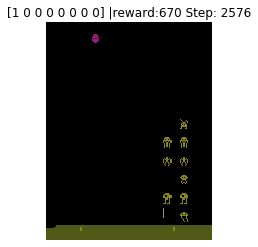

Score 670.0


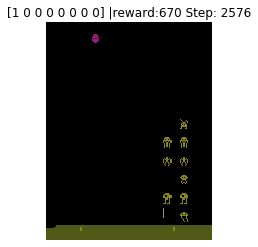

In [38]:
with tf.Session() as sess:
    env.reset()
    total_test_rewards = []
    step=0
    # Load the model
    saver.restore(sess, "./models/model2.ckpt")
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = prep_stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            #print(state.shape)
            #print(state.sum())
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(QNetwork.output, feed_dict = {QNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            #print(choice)
            action = possible_actions[choice]
            
            #Perform the action and get the next_state, reward, and done information
            next_state, r1, done, _ = env.step(action)
            next_state, r2, done, _ = env.step(action)
            reward=r1+r2
            #env.render()
            show_state(env,total_rewards,step,action)
            #render = lambda : plt.imshow(env.render(mode='rgb_array'))
            #show_img(next_state)
            #PIL.Image.fromarray(next_state)
            step+=1
            #print(reward, done,action)
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            next_state, stacked_frames = prep_stack_frames(stacked_frames, next_state, False)
            state = next_state
            
#     env.close()

In [37]:
Qs_m=[]
with tf.Session() as sess:
    saver.restore(sess, "./models/model.ckpt")    
    i=0
    rt=0
    while (i+8 < len(memory.buffer)):
        batch=[memory.buffer[k] for k in range(i,i+8)]
        #batch = memory.buffer[i:]
        states_mb = np.array([each[0] for each in batch], ndmin=3)
        actions_mb = np.array([each[1] for each in batch])
        rewards_mb = np.array([each[2] for each in batch]) 
        next_states_mb = np.array([each[3] for each in batch], ndmin=3)
        dones_mb = np.array([each[4] for each in batch])
        Qs = sess.run(QNetwork.output, feed_dict = {QNetwork.inputs_: states_mb})
        print(rewards_mb,Qs.sum())
        Qs_m.append(Qs)
        if(rewards_mb.sum()>0):
            rt+=1 
        i=i+8
print(rt)
    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/model.ckpt
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 5. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 10.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0. 15.  0.  0.  0.  0.  0.  0.] 42.539474
[ 0.  0.  0.  0.  0.  0.  0. 20.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 25.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0. 30.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0. 25.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[30.  0.  0.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 5. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0. 20.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 25.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 20.  0.  0.  0.  0.  0.] 42.539474
[5. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[   0. -100.    0.    0.    0.    0.    0.    0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0.  0. 25.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0.  0. 30.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0. 10.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0. 15.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0. 10.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[5. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0. 15.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[20.  0.  0.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 25.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 5. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0. 10.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[   0. -100.    0.    0.    0.    0.    0.    0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 25.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0. 30.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0. 25.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0.  0. 30.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0. 20.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[   0. -100.    0.    0.    0.    0.    0.    0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0. 15.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0. 30.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 5. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 5. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0. 20.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[5. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0. 10.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[15.  0.  0.

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[   0.    0.    0.    0. -100.    0.    0.    0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0. 30.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 5. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0. 10.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 15.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 20.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539

[ 0.  0.  0.  0.  0.  0.  0. 15.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 5. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0. 10.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[20.  0.  0.  0.  0.  0.  0.  0.] 42.539474
[ 0.  0.  0.  0.  0.  0. 25.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[10.  0.  0.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0. 15.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0. 20.  0.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 25.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 5. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0.  0. 10.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0. 15.  0.] 42.539474
[0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[   0.    0. -100.    0.    0.    0.    0.    0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0. 15.  0. 30.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 5. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0. 10.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[-100.    0.    0.    0.    0.    0.    0.    0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[  0.   0.   0. 200.   0.   0.   0.   0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0. 25.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 5. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 5. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 5. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0. 10.  0.  0.  0.  0.  0.  0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[ 0.  0.  0.  0.  0.  0.  0. 15.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42.539474
[0. 0. 0. 0. 0. 0. 0. 0.] 42

598


In [ ]:
len(memory.buffer)

In [ ]:
[rewards_mb[i] for i in range(8)]

In [ ]:
from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "QNetwork")
from_vars

In [ ]:
 [v for v in tf.trainable_variables() if v.name == 'QNetwork/conv1/kernel:0'][0]

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./models/model.ckpt")  
    vars = tf.trainable_variables()
    print(vars) #some infos about variables...
    vars_vals = sess.run(vars)
    for var, val in zip(vars, vars_vals):
        print("var: {}, value: {}".format(var.name, val)) 